In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import corner
from scipy import stats
import pint.models
from copy import deepcopy
import scipy
pi = np.pi

params_true=[3.5, -13, -4.698970004336019, 4.584991623131289, 2.0707963267948966, 2.0707963267948966]
PSR J0023+0923_synthetic_injected5
Chain shape = (500001, 10)


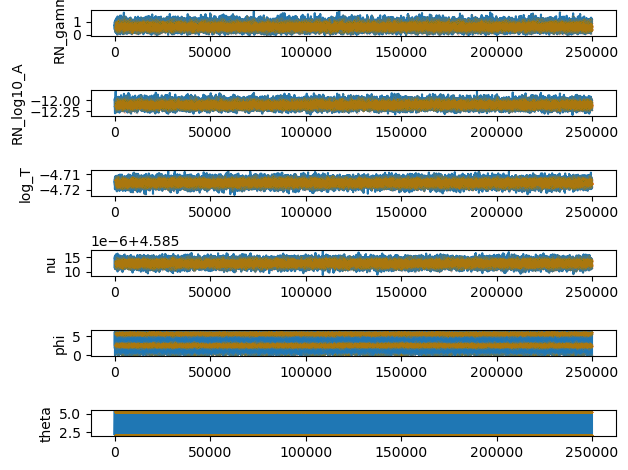

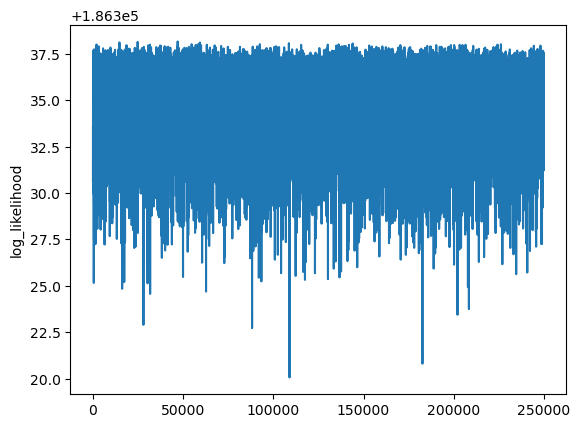

<Figure size 640x480 with 0 Axes>

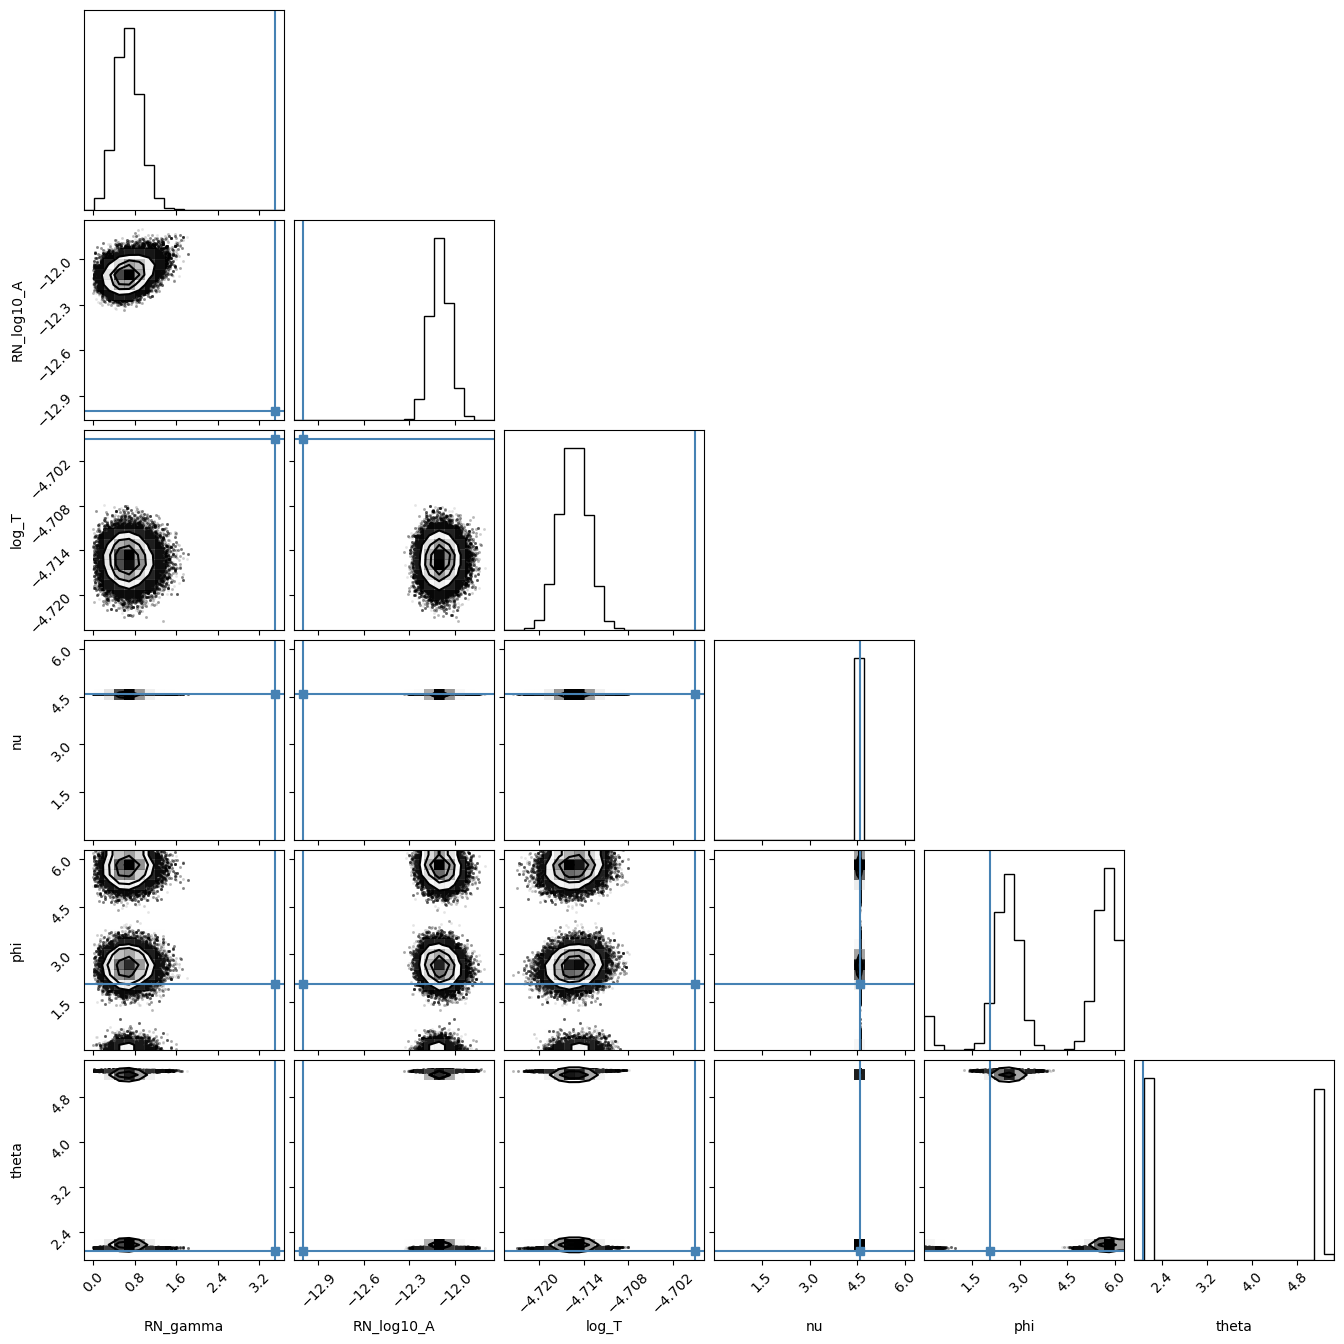

In [2]:
psr = "J0023+0923_synthetic_injected5"
# psrlist = ['J0023+0923',]
log_T_true = np.log10(2*10**-(float(psr[-1])))
nu_expected = 3.3343e-04
phi_plus = 1
phi_minus = pi
theta = (phi_plus + phi_minus) / 2
phi = (phi_plus - phi_minus) / 2
params_true = [3.5, -13, log_T_true, nu_expected * 86400 / (2*np.pi), phi+pi, theta]
print(f"{params_true=}")

chain_folder = "/lorule/scratch/jdt00012/May/chains_06May_2025/"

# params = ['log_T', 'nu', 'phi_minus', 'phi_plus']
params = ['RN_gamma', 'RN_log10_A', 'log_T', 'nu', 'phi', 'theta']


chain_file = f"{chain_folder}/{psr}/chain_1.0.txt"
# chain_file = f"{chain_folder}/{psr}/chain_2.488033871712585.txt"
# chain_file = f"{chain_folder}/{psr}/chain_hot.txt"
# chain_file = f"{chain_folder}/{psr}/chain_1.5773502691896257.txt"
chain = np.genfromtxt(chain_file)
print(f"PSR {psr}")
print(f"Chain shape = {chain.shape}")
chain[:,3] *= 86400 / (2*np.pi) # convert 2pi/s to 1/day
chain[:,4] %= (2*np.pi)
chain[:,5] %= (2*np.pi)
ndim = len(params)
percent_burn = 0.5
burn = int(chain.shape[0] * percent_burn)
fig, axs = plt.subplots(ndim, 1)
ranges = []
for i, param in enumerate(params):
    ax = axs[i]
    ax.plot(chain[burn:, i], ls='-', marker=None, alpha=1.0)
    ax.plot(chain[burn:, i], "o", markersize = 0.01)
    ax.set_ylabel(param)
    
    param_chain = chain[burn:, i]
    t = params_true[i]
    minval = min(np.min(param_chain), t)
    maxval = max(np.max(param_chain), t)
    pad = 0.05 * (maxval - minval)  # 5% padding
    if i == 3 or i == 4:
        ranges.append((0., 2*pi))
    else:
        ranges.append((minval - pad, maxval + pad))
    
fig.tight_layout()
plt.show()

plt.plot(chain[burn:, -3])
plt.ylabel('log_likelihood')
plt.show()

T_strength = psr[-1]
if T_strength == "l":
    T_strength = "0 (in other words, no signal by design)"
else:
    T_strength = f"1e-{T_strength}"
# corner.corner(chain[burn:,2:-4], labels=params,  plot_contours=True)
plt.suptitle(f"Posteriors for T = {T_strength} seconds INJECTED SIGNAL | J0023+0923")
corner.corner(chain[burn:,:-4], labels=params,  plot_contours=True, truths = params_true, range=ranges)
plt.show()

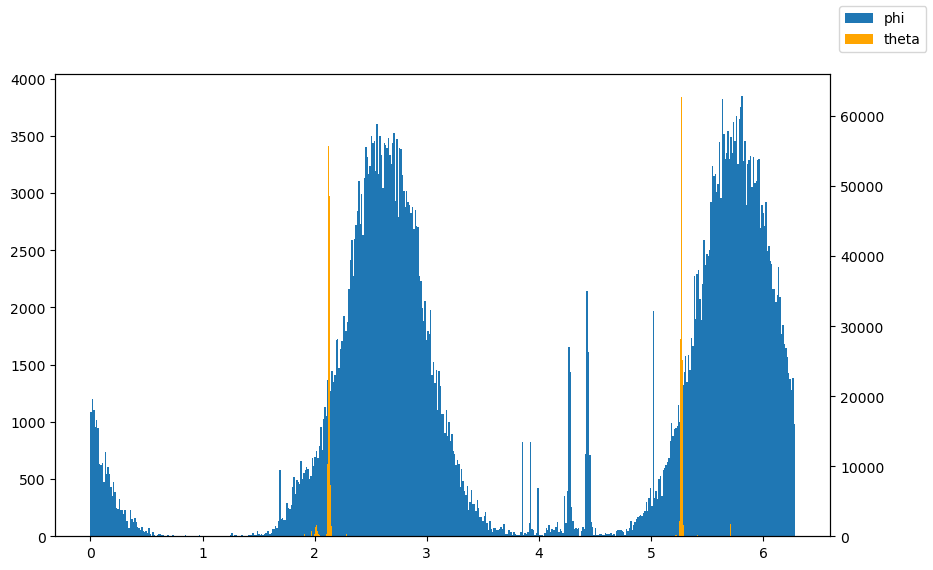

In [3]:
S = chain[:,2]
nu = chain[:,3]
phi = chain[:,4]
theta = chain[:,5]

fig, ax = plt.subplots(figsize = (10,6))
ax.twinx().hist(theta, bins = 1000, color = "orange", label="theta")
ax.hist(phi, bins = 500, label = "phi")
fig.legend()
plt.show()

In [4]:
par = "red_noise_and_injected/J0023+0923_synthetic_injected4.par"
tim = "red_noise_and_injected/J0023+0923_synthetic_injected4.tim"
pint.logging.setup(level="WARNING")

model_base, toas_base = pint.models.get_model_and_toas(par, tim)


In [5]:
model = deepcopy(model_base)
toas = deepcopy(toas_base)
mjds = toas.get_mjds().value

FB0 = model.FB0.value * 86400
n_b = FB0 * 2 *pi

t_min = np.min(mjds)
t_max = np.min(mjds)

t_avg = (t_min + t_max) / 2

In [6]:
theta_ = (n_b * t_avg + theta) % (2*pi)
phi_ = (nu * t_avg + phi) % (2*pi)
new_chain = deepcopy(chain)
new_chain[:,4] = phi_
new_chain[:,5] = theta_

new_params_true = deepcopy(params_true)
new_params_true[4] = (params_true[3] * t_avg + params_true[4]) % (2*pi)
new_params_true[5] = (n_b * t_avg + params_true[5]) % (2*pi)
print(new_params_true)

[3.5, -13, -4.698970004336019, 4.584991623131289, 3.374573595234665, 0.25165205484262287428]


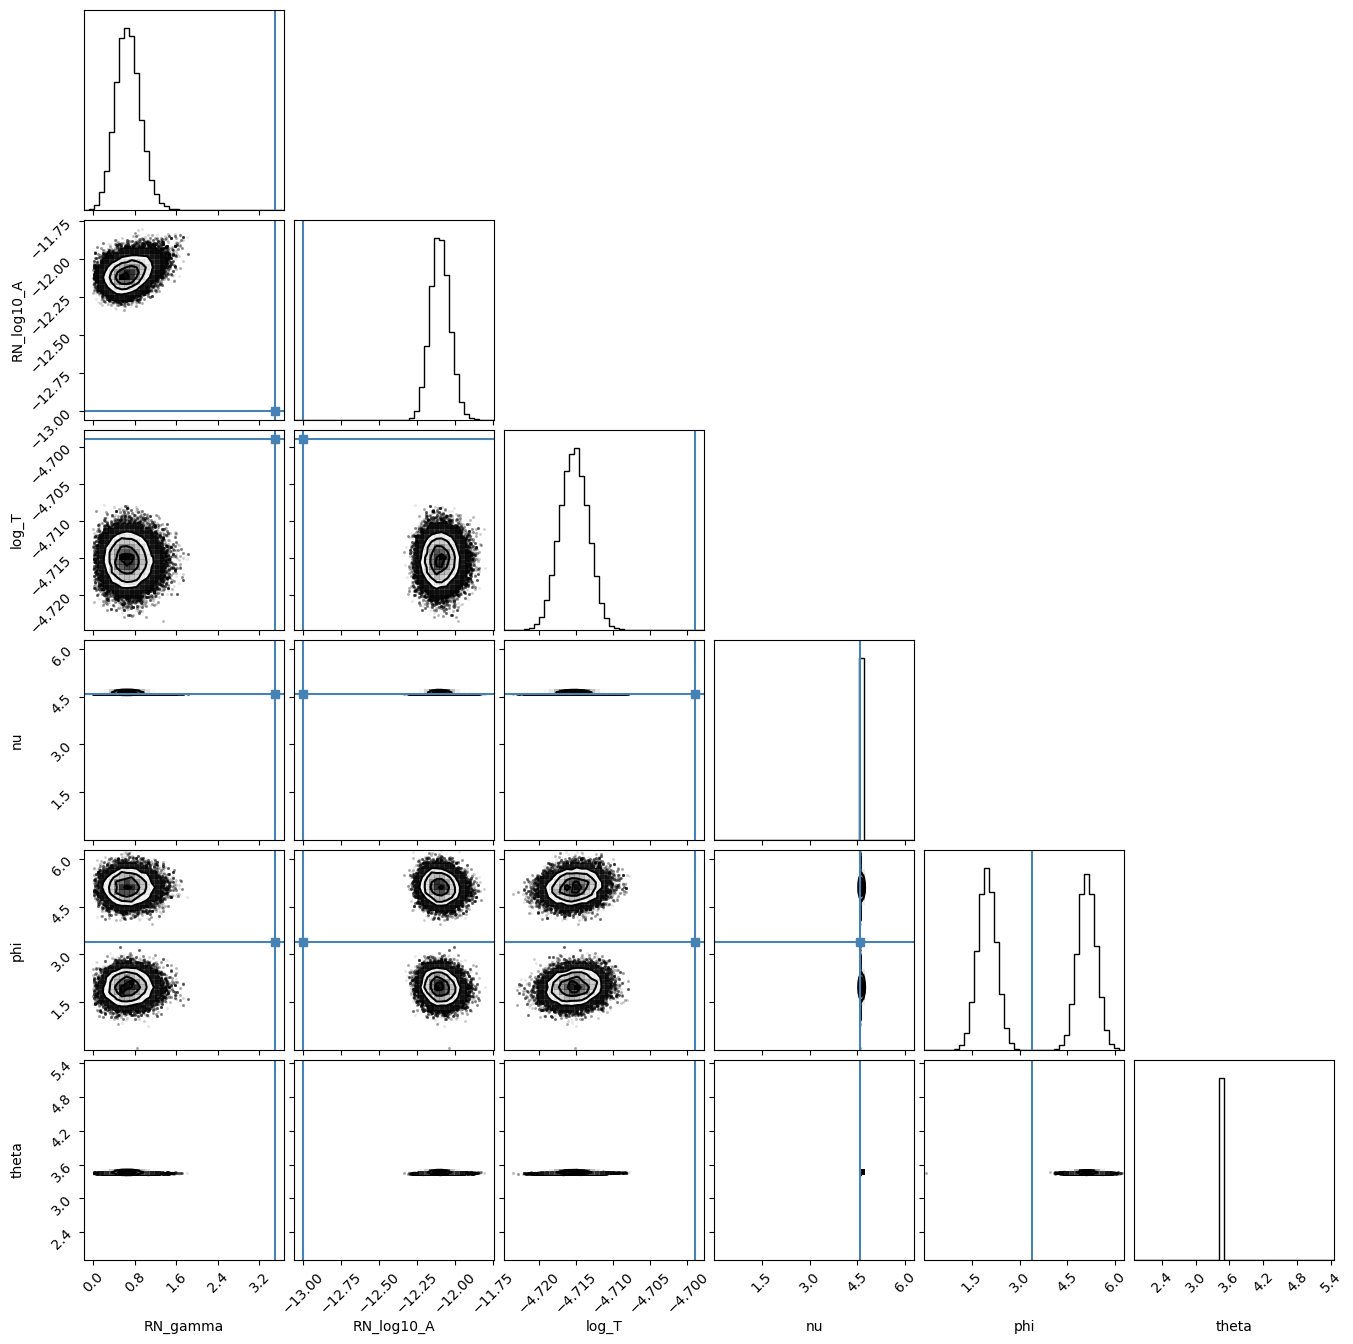

In [7]:
corner.corner(new_chain[burn:,:-4], bins = 40, labels=params,  plot_contours=True, truths = new_params_true, range = ranges, max_n_ticks=6)
plt.show()

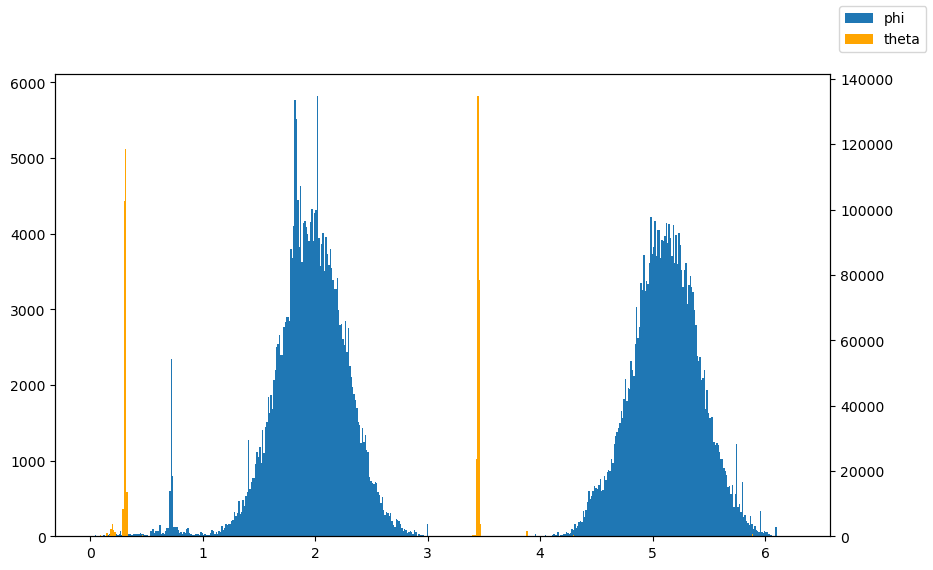

In [8]:
fig, ax = plt.subplots(figsize = (10,6))
ax.twinx().hist(theta_, bins = 500, color = "orange", label="theta")
ax.hist(phi_, bins = 500, label = "phi")
fig.legend()
plt.show()

In [22]:
res = scipy.stats.bootstrap(
    data=(phi % pi,),                     # data should be passed as a tuple
    statistic=np.mean,                 # function to apply
    confidence_level=0.68,             # for 1-sigma (~68%) confidence interval
    n_resamples=5000,                # more = better precision
    method='basic',                    # basic, percentile, or BCa (bias-corrected)
    random_state=42                    # for reproducibility (optional)
)

# Extract values
mean_estimate = np.mean(chain)
std_dev = (res.confidence_interval.high - res.confidence_interval.low) / 2

print(f"{std_dev=}")

std_dev=0.0009781927308936123


(array([  1.,   3.,  15.,  23.,  47., 110., 178., 287., 451., 544., 647.,
        707., 638., 494., 367., 228., 137.,  76.,  27.,  20.]),
 array([2.36502217, 2.36536008, 2.36569798, 2.36603589, 2.3663738 ,
        2.36671171, 2.36704962, 2.36738753, 2.36772544, 2.36806335,
        2.36840126, 2.36873916, 2.36907707, 2.36941498, 2.36975289,
        2.3700908 , 2.37042871, 2.37076662, 2.37110453, 2.37144243,
        2.37178034]),
 <BarContainer object of 20 artists>)

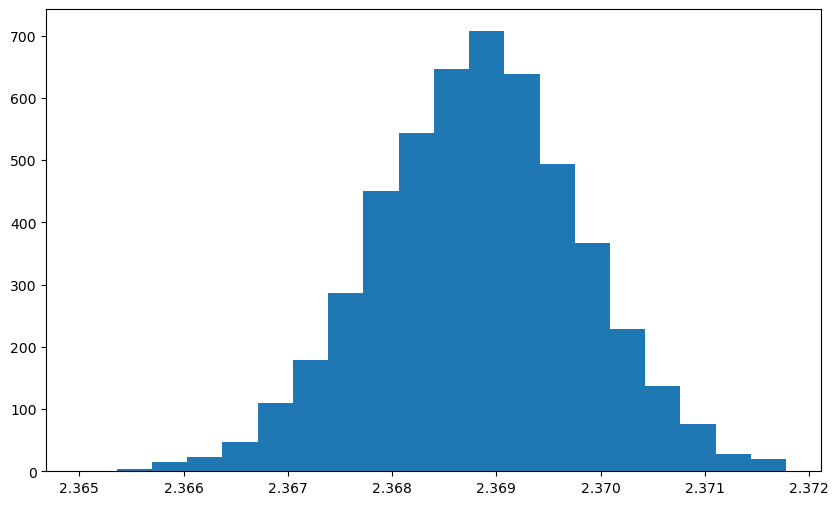

In [23]:
fig, ax = plt.subplots(figsize = (10,6))
ax.hist(res.bootstrap_distribution, bins = 20)

In [21]:
print(np.std(phi))

1.6910508321961966


(array([8.6810e+03, 4.5750e+03, 1.9400e+03, 8.1700e+02, 2.3500e+02,
        6.3000e+01, 1.6000e+01, 9.0000e+00, 0.0000e+00, 1.7000e+01,
        6.3000e+01, 1.5300e+02, 3.0000e+02, 1.8270e+03, 4.1690e+03,
        5.8640e+03, 9.5540e+03, 1.5665e+04, 2.3194e+04, 3.1217e+04,
        3.3577e+04, 3.3016e+04, 2.9668e+04, 2.2215e+04, 1.4389e+04,
        8.7730e+03, 4.5240e+03, 2.4070e+03, 8.6900e+02, 5.0700e+02,
        1.0030e+03, 1.5850e+03, 4.7500e+02, 2.8850e+03, 2.2220e+03,
        5.5470e+03, 1.8400e+02, 3.3700e+02, 1.0900e+03, 4.2970e+03,
        4.8890e+03, 9.4510e+03, 1.6283e+04, 2.3164e+04, 3.2294e+04,
        3.4332e+04, 3.3797e+04, 3.0149e+04, 2.2758e+04, 1.4955e+04]),
 array([2.51504873e-05, 1.25687770e-01, 2.51350390e-01, 3.77013010e-01,
        5.02675630e-01, 6.28338250e-01, 7.54000870e-01, 8.79663490e-01,
        1.00532611e+00, 1.13098873e+00, 1.25665135e+00, 1.38231397e+00,
        1.50797659e+00, 1.63363921e+00, 1.75930183e+00, 1.88496445e+00,
        2.01062707e+00, 2.1362

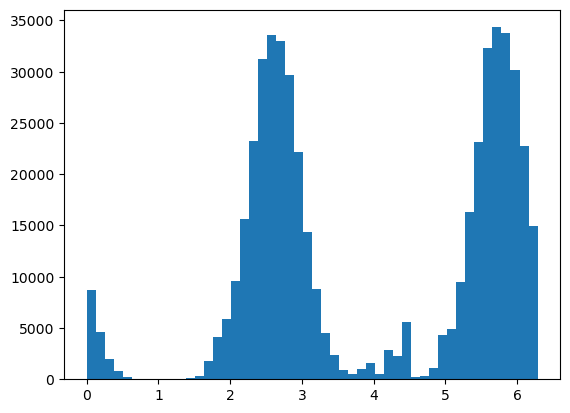

In [26]:
plt.hist(phi, bins = 50)

(array([  340.,  1848.,  2625.,   307.,  4889.,   728.,   105.,   234.,
          205.,   412.,  1301.,  1466.,  2702.,  5630.,  4867.,  5661.,
         8144., 10526., 14004., 17246., 20758., 25075., 29538., 33244.,
        33940., 34028., 34584., 32223., 31580., 28645., 25143., 20492.,
        16808., 13263., 10303.,  7711.,  5626.,  3635.,  2752.,  1654.,
         1262.,   581.,   515.,   237.,   150.,   923.,  1101.,   507.,
          142.,   341.]),
 array([1.00170212, 1.06446524, 1.12722836, 1.18999147, 1.25275459,
        1.31551771, 1.37828083, 1.44104395, 1.50380706, 1.56657018,
        1.6293333 , 1.69209642, 1.75485954, 1.81762265, 1.88038577,
        1.94314889, 2.00591201, 2.06867513, 2.13143825, 2.19420136,
        2.25696448, 2.3197276 , 2.38249072, 2.44525384, 2.50801695,
        2.57078007, 2.63354319, 2.69630631, 2.75906943, 2.82183254,
        2.88459566, 2.94735878, 3.0101219 , 3.07288502, 3.13564813,
        3.19841125, 3.26117437, 3.32393749, 3.38670061, 3.44946372

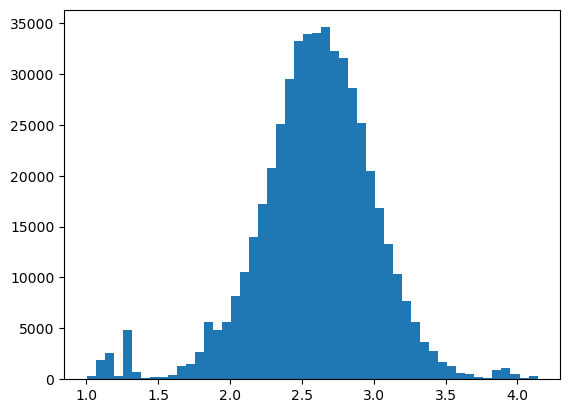

In [27]:
phi_adj = phi % pi
mask = phi_adj < 1
phi_adj[mask] = phi_adj[mask] + pi
plt.hist(phi_adj, bins = 50)

In [39]:
res = scipy.stats.bootstrap(
    data=(phi_adj,),                     # data should be passed as a tuple
    statistic=np.mean,                 # function to apply
    confidence_level=0.68,             # for 1-sigma (~68%) confidence interval
    n_resamples=1000,                # more = better precision
    method='basic',                    # basic, percentile, or BCa (bias-corrected)
    random_state=42                    # for reproducibility (optional)
)

# Extract values
mean_estimate = np.mean(phi_adj)
std_dev = (res.confidence_interval.high - res.confidence_interval.low) / 2

print(f"{mean_estimate=}")
print(f"{std_dev=}")

mean_estimate=2.597931697796344
std_dev=0.0006034389756051084


(array([  6.,   7.,  13.,  20.,  38.,  62.,  80., 100., 108., 104., 114.,
         97.,  85.,  66.,  42.,  23.,  18.,  11.,   3.,   3.]),
 array([2.59619681, 2.59637003, 2.59654324, 2.59671645, 2.59688967,
        2.59706288, 2.59723609, 2.59740931, 2.59758252, 2.59775573,
        2.59792895, 2.59810216, 2.59827537, 2.59844859, 2.5986218 ,
        2.59879501, 2.59896823, 2.59914144, 2.59931465, 2.59948787,
        2.59966108]),
 <BarContainer object of 20 artists>)

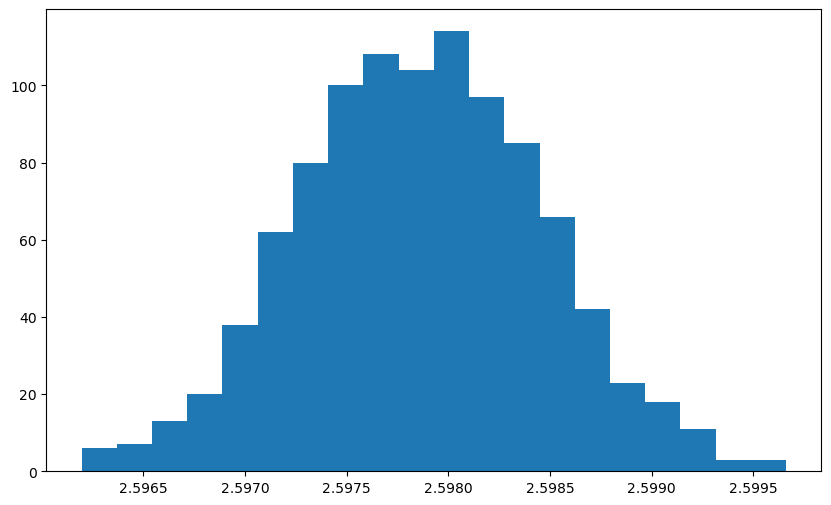

In [29]:
fig, ax = plt.subplots(figsize = (10,6))
ax.hist(res.bootstrap_distribution, bins = 20)

(array([8.00000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 3.00000e+00, 2.10000e+01, 2.96000e+02,
        3.00000e+01, 3.43100e+03, 7.30200e+03, 1.52300e+03, 4.83674e+05,
        6.10000e+01, 5.80000e+01, 4.22000e+02, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.70000e+03, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 3.80000e+01,
        0.00000e+00, 4.82000e+02, 1.00000e+01, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.50000e+02]),
 array([1.42797205, 1.47639674, 1.52482142, 1.57324611, 1.6216708 ,
        1.67009548, 1.71852017, 1.76694485, 1.81536954, 1.86379422,
        1.91221891, 1.9606436 , 2.00906828, 2.05749297, 2.10591765,
        2.15434234, 2.20276703, 2.25119171, 2.2996164 , 2.348041

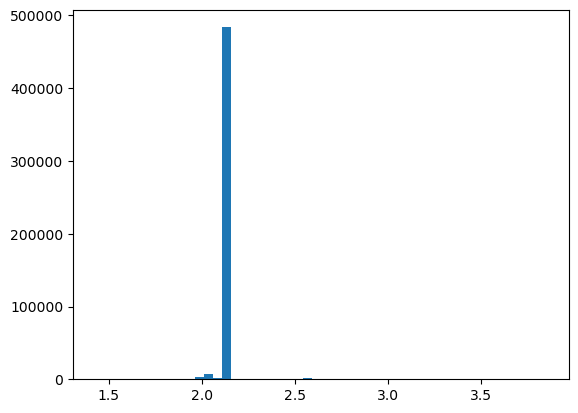

In [31]:
theta_adj = theta % pi
mask = theta_adj < 1
theta_adj[mask] = theta_adj[mask] + pi
plt.hist(theta_adj, bins = 50)

In [38]:
res = scipy.stats.bootstrap(
    data=(theta_adj,),                     # data should be passed as a tuple
    statistic=np.mean,                 # function to apply
    confidence_level=0.68,             # for 1-sigma (~68%) confidence interval
    n_resamples=1000,                # more = better precision
    method='basic',                    # basic, percentile, or BCa (bias-corrected)
    random_state=42                    # for reproducibility (optional)
)

# Extract values
mean_estimate = np.mean(theta_adj)
std_dev = (res.confidence_interval.high - res.confidence_interval.low) / 2

print(f"{mean_estimate=}")
print(f"{std_dev=}")

mean_estimate=2.1273885078200925
std_dev=8.031582891354638e-05


(array([  9.,  15.,  33.,  33.,  82.,  98., 102., 104., 108., 113.,  97.,
         73.,  58.,  30.,  20.,  13.,   7.,   3.,   1.,   1.]),
 array([2.12718927, 2.12721333, 2.12723739, 2.12726145, 2.12728551,
        2.12730957, 2.12733363, 2.12735769, 2.12738175, 2.12740581,
        2.12742987, 2.12745393, 2.12747799, 2.12750205, 2.12752611,
        2.12755017, 2.12757423, 2.12759829, 2.12762235, 2.12764641,
        2.12767047]),
 <BarContainer object of 20 artists>)

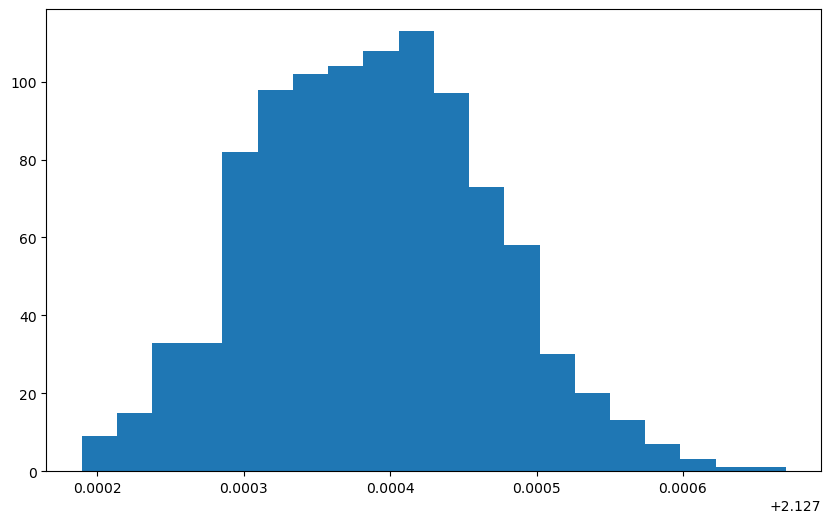

In [33]:
fig, ax = plt.subplots(figsize = (10,6))
ax.hist(res.bootstrap_distribution, bins = 20)

In [34]:
np.std(theta_adj)

0.05885207560365963

In [35]:
np.std(phi_adj)

0.41733144906526304